# Barren Plateaus

<em> Copyright (c) 2021 Institute for Quantum Computing, Baidu Inc. All Rights Reserved. </em>

## Overview

In the training of classical neural networks, gradient-based optimization methods encounter the problem of local minimum and saddle points. Correspondingly, the Barren plateau phenomenon could potentially block us from efficiently training quantum neural networks. This peculiar phenomenon was first discovered by McClean et al. in 2018 [[arXiv:1803.11173]](https://arxiv.org/abs/1803.11173). In few words, when we randomly initialize the parameters in random circuit structure meets a certain degree of complexity, the optimization landscape will become very flat, which makes it difficult for the optimization method based on gradient descent to find the global minimum. For most variational quantum algorithms (VQE, etc.), this phenomenon means that when the number of qubits increases, randomly choose a circuit ansatz and randomly initialize the parameters of it may not be a good idea. This will make the optimization landscape corresponding to the loss function into a huge plateau, which makes the quantum neural network's training much more difficult. The initial random value for the optimization process is very likely to stay inside this plateau, and the convergence time of gradient descent will be prolonged.

![BP-fig-barren](./figures/BP-fig-barren.png)

The figure is generated through [Gradient Descent Viz](https://github.com/lilipads/gradient_descent_viz)

This tutorial mainly discusses how to show the barren plateau phenomenon with Paddle Quantum. Although it does not involve any algorithm innovation, it can improve readers' understanding about gradient-based training for quantum neural network. We first introduce the necessary libraries and packages:

In [1]:
import time
import numpy as np
from matplotlib import pyplot as plt 
import paddle
from paddle import matmul
from paddle_quantum.circuit import UAnsatz
from paddle_quantum.utils import dagger
from paddle_quantum.state import density_op

## Random network structure

Here we follow the original method mentioned in the paper by McClean (2018) and build the following random circuit (currently we do not support the built-in control-Z gate, use CNOT instead):

![BP-fig-Barren_circuit](./figures/BP-fig-Barren_circuit.png)

First, we rotate all the qubits around the $y$-axis of the Bloch sphere with rotation gates $R_y(\pi/4)$.

The remaining structure forms a block, each block can be further divided into two layers:

- Build a layer of random rotation gates on all the qubits, where $R_{\ell,n} \in \{R_x, R_y, R_z\}$. The subscript $\ell$ means the gate is in the $\ell$-th repeated block. In the figure above, $\ell =1$. The second subscript $n$ indicates which qubit it acts on.
- The second layer is composed of CNOT gates, which act on adjacent qubits.

In Paddle Quantum, we can build this circuit with the following code:

In [2]:
def rand_circuit(theta, target, num_qubits):

    # We need to convert Numpy array to Tensor in PaddlePaddle
    const = paddle.to_tensor(np.array([np.pi/4]))
    
    # Initialize the quantum circuit
    cir = UAnsatz(num_qubits)
    
    # ============== First layer ==============
    # Fixed-angle Ry rotation gates 
    for i in range(num_qubits):
        cir.ry(const, i)

    # ============== Second layer ==============
    # Target is a random array help determine rotation gates
    for i in range(num_qubits):
        if target[i] == 0:
            cir.rz(theta[i], i)
        elif target[i] == 1:
            cir.ry(theta[i], i)
        else:
            cir.rx(theta[i], i)
            
    # ============== Third layer ==============
    # Build adjacent CNOT gates
    for i in range(num_qubits - 1):
        cir.cnot([i, i + 1])
        
    return cir.U

## Loss function and optimization landscape

After determining the circuit structure, we also need to define a loss function to determine the optimization landscape. Following the same set up with McClean (2018), we take the loss function from VQE:

$$
\mathcal{L}(\boldsymbol{\theta})= \langle0| U^{\dagger}(\boldsymbol{\theta})H U(\boldsymbol{\theta}) |0\rangle,
\tag{1}
$$

The unitary matrix $U(\boldsymbol{\theta})$ is the quantum neural network with the random structure we built from the last section. For Hamiltonian $H$, we also take the simplest form $H = |00\cdots 0\rangle\langle00\cdots 0|$. After that, we can start sampling gradients with the two-qubit case - generate 300 sets of random network structures and different random initial parameters $\{\theta_{\ell,n}^{( i)}\}_{i=1}^{300}$. Each time the partial derivative with respect to the **first parameter $\theta_{1,1}$** is calculated according to the analytical gradient formula from VQE. Then analyze the mean and variance of these 300 sampled partial gradients. The formula for the analytical gradient is:

$$
\partial \theta_{j} 
\equiv \frac{\partial \mathcal{L}}{\partial \theta_j}
= \frac{1}{2} \big[\mathcal{L}(\theta_j + \frac{\pi}{2}) - \mathcal{L}(\theta_j - \frac{\pi}{2})\big].
\tag{2}
$$

For a detailed derivation, see [arXiv:1803.00745](https://arxiv.org/abs/1803.00745).

In [3]:
# Hyper parameter settings
np.random.seed(42)   # Fixed Numpy random seed
N = 2                # Set the number of qubits
samples = 300        # Set the number of sampled random network structures
THETA_SIZE = N       # Set the size of the parameter theta
ITR = 1              # Set the number of iterations
LR = 0.2             # Set the learning rate
SEED = 1             # Fixed the randomly initialized seed in the optimizer

# Initialize the register for the gradient value
grad_info = []

paddle.seed(SEED)
class manual_gradient(paddle.nn.Layer):
    
    # Initialize a list of learnable parameters and fill the initial value with a uniform distribution of [0, 2*pi]
    def __init__(self, shape, param_attr= paddle.nn.initializer.Uniform(
        low=0.0, high=2 * np.pi),dtype='float64'):
        super(manual_gradient, self).__init__()
        
        # Convert Numpy array to Tensor in PaddlePaddle
        self.H = paddle.to_tensor(density_op(N))
        
    # Define loss function and forward propagation mechanism  
    def forward(self):
        
        # Initialize three theta parameter lists
        theta_np = np.random.uniform(low=0., high= 2 * np.pi, size=(THETA_SIZE))
        theta_plus_np = np.copy(theta_np) 
        theta_minus_np = np.copy(theta_np) 
        
        # Modified to calculate analytical gradient
        theta_plus_np[0] += np.pi/2
        theta_minus_np[0] -= np.pi/2
        
        # Convert Numpy array to Tensor in PaddlePaddle
        theta = paddle.to_tensor(theta_np)
        theta_plus = paddle.to_tensor(theta_plus_np)
        theta_minus = paddle.to_tensor(theta_minus_np)
        
        # Generate random targets, randomly select circuit gates in rand_circuit
        target = np.random.choice(3, N)      
        
        U = rand_circuit(theta, target, N)
        U_dagger = dagger(U) 
        U_plus = rand_circuit(theta_plus, target, N)
        U_plus_dagger = dagger(U_plus) 
        U_minus = rand_circuit(theta_minus, target, N)
        U_minus_dagger = dagger(U_minus) 

        # Calculate the analytical gradient
        grad = (paddle.real(matmul(matmul(U_plus_dagger, self.H), U_plus))[0][0]  
                - paddle.real(matmul(matmul(U_minus_dagger, self.H), U_minus))[0][0])/2 
        
        return grad

# Define the main block
def main():

    # Set the dimension of QNN
    sampling = manual_gradient(shape=[THETA_SIZE])
        
    # Sampling to obtain gradient information
    grad = sampling()   
        
    return grad.numpy()

# Record running time
time_start = time.time()

# Start sampling
for i in range(samples):
    if __name__ == '__main__':
        grad = main()
        grad_info.append(grad)

time_span = time.time() - time_start

print('The main program segment has run in total ', time_span, ' seconds')
print("Use ", samples, " samples to get the mean value of the gradient of the random network's first parameter, and we have：", np.mean(grad_info))
print("Use ", samples, "samples to get the variance of the gradient of the random network's first parameter, and we have：", np.var(grad_info))

The main program segment has run in total  5.674382448196411  seconds
Use  300  samples to get the mean value of the gradient of the random network's first parameter, and we have： 0.005925709445960606
Use  300 samples to get the variance of the gradient of the random network's first parameter, and we have： 0.028249053148446363


## Visualization of the Optimization landscape

Next, we use Matplotlib to visualize the optimization landscape. In the case of **two qubits**, we only have two parameters $\theta_1$ and $\theta_2$, and there are 9 possibilities for the random circuit structure in the second layer. 

![BP-fig-landscape2](./figures/BP-fig-landscape2.png)

The plain structure shown in the $R_z$-$R_z$ layer from the last figure is something we should avoid. In this case, it's nearly impossible to converge to the theoretical minimum. If you want to try to draw some optimization landscapes yourself, please refer to the following code:

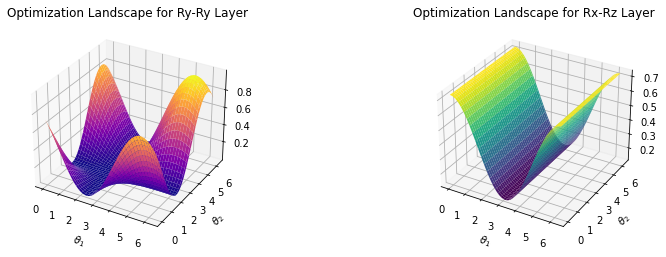

The main program segment has run in total  1.9106006622314453  seconds


In [4]:
# Introduce the necessary packages
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter

time_start = time.time()
N = 2

# Set the image ratio Vertical: Horizontal = 0.3
fig = plt.figure(figsize=plt.figaspect(0.3))

# Generate points on the x, y axis
X = np.linspace(0, 2 * np.pi, 80)
Y = np.linspace(0, 2 * np.pi, 80)

# Generate 2D mesh
xx, yy = np.meshgrid(X, Y)


# Define the necessary logic gates
def rx(theta):
    mat = np.array([[np.cos(theta/2), -1j * np.sin(theta/2)],
                    [-1j * np.sin(theta/2), np.cos(theta/2)]])
    return mat

def ry(theta):
    mat = np.array([[np.cos(theta/2), -1 * np.sin(theta/2)],
                    [np.sin(theta/2), np.cos(theta/2)]])
    return mat

def rz(theta):
    mat = np.array([[np.exp(-1j * theta/2), 0],
                    [0, np.exp(1j * theta/2)]])
    return mat

def CNOT():
    mat = np.array([[1,0,0,0],[0,1,0,0],[0,0,0,1],[0,0,1,0]])
    return mat

# ============= The first figure =============
# We visualize the case where the second layer is kron(Ry, Ry)
ax = fig.add_subplot(1, 2, 1, projection='3d')

# Forward propagation to calculate loss function:
def cost_yy(para):
    L1 = np.kron(ry(np.pi/4), ry(np.pi/4))
    L2 = np.kron(ry(para[0]), ry(para[1]))
    U = np.matmul(np.matmul(L1, L2), CNOT())
    H = np.zeros((2 ** N, 2 ** N))
    H[0, 0] = 1
    val = (U.conj().T @ H@ U).real[0][0]
    return val

# Draw an image
Z = np.array([[cost_yy([x, y]) for x in X] for y in Y]).reshape(len(Y), len(X))
surf = ax.plot_surface(xx, yy, Z, cmap='plasma')
ax.set_xlabel(r"$\theta_1$")
ax.set_ylabel(r"$\theta_2$")
ax.set_title("Optimization Landscape for Ry-Ry Layer")

# ============= The second figure =============
# We visualize the case where the second layer is kron(Rx, Rz)
ax = fig.add_subplot(1, 2, 2, projection='3d')


def cost_xz(para):
    L1 = np.kron(ry(np.pi/4), ry(np.pi/4))
    L2 = np.kron(rx(para[0]), rz(para[1]))
    U = np.matmul(np.matmul(L1, L2), CNOT())
    H = np.zeros((2 ** N, 2 ** N))
    H[0, 0] = 1
    val = (U.conj().T @ H @ U).real[0][0]
    return val

Z = np.array([[cost_xz([x, y]) for x in X] for y in Y]).reshape(len(Y), len(X))
surf = ax.plot_surface(xx, yy, Z, cmap='viridis')
ax.set_xlabel(r"$\theta_1$")
ax.set_ylabel(r"$\theta_2$")
ax.set_title("Optimization Landscape for Rx-Rz Layer")


plt.show()

time_span = time.time() - time_start        
print('The main program segment has run in total ', time_span, ' seconds')

## More qubits

Then, we will see what happens to the sampled gradients when we increase the number of qubits

In [5]:
# Hyper parameter settings
selected_qubit = [2, 4, 6, 8]
samples = 300
grad_val = []
means, variances = [], []

# Record operation time
time_start = time.time()

# Keep increasing the number of qubits
for N in selected_qubit:
    grad_info = []
    THETA_SIZE = N
    for i in range(samples):
        class manual_gradient(paddle.nn.Layer):
            
            # Initialize a list of learnable parameters of length THETA_SIZE
            def __init__(self, shape, param_attr=paddle.nn.initializer.Uniform(low=0.0, high=2 * np.pi),dtype='float64'):
                super(manual_gradient, self).__init__()

                # Convert to Tensor in PaddlePaddle
                self.H = paddle.to_tensor(density_op(N))

            # Define loss function and forward propagation mechanism  
            def forward(self):

                
                # Initialize three theta parameter lists
                theta_np = np.random.uniform(low=0., high= 2 * np.pi, size=(THETA_SIZE))
                theta_plus_np = np.copy(theta_np) 
                theta_minus_np = np.copy(theta_np) 

                
                # Modify to calculate analytical gradient
                theta_plus_np[0] += np.pi/2
                theta_minus_np[0] -= np.pi/2

                # Convert to Tensor in PaddlePaddle
                theta = paddle.to_tensor(theta_np)
                theta_plus = paddle.to_tensor(theta_plus_np)
                theta_minus = paddle.to_tensor(theta_minus_np)

                # Generate random targets, randomly select circuit gates in rand_circuit
                target = np.random.choice(3, N)      
                
                U = rand_circuit(theta, target, N)
                U_dagger = dagger(U) 
                U_plus = rand_circuit(theta_plus, target, N)
                U_plus_dagger = dagger(U_plus) 
                U_minus = rand_circuit(theta_minus, target, N)
                U_minus_dagger = dagger(U_minus) 

                
                # Calculate analytical gradient
                grad = (paddle.real(matmul(matmul(U_plus_dagger, self.H), U_plus))[0][0]  
                        - paddle.real(matmul(matmul(U_minus_dagger, self.H), U_minus))[0][0])/2
                
                return grad      
            
           
        # Define the main program segment    
        def main():
            
            # Set the dimension of QNN
            sampling = manual_gradient(shape=[THETA_SIZE])
                
            # Sampling to obtain gradient information
            grad = sampling()
                
            return grad.numpy()
        
        if __name__ == '__main__':
            grad = main()
            grad_info.append(grad)
            
    # Record sampling information
    grad_val.append(grad_info) 
    means.append(np.mean(grad_info))
    variances.append(np.var(grad_info))

time_span = time.time() - time_start
print('The main program segment has run in total ', time_span, ' seconds')

The main program segment has run in total  90.05470848083496  seconds


We then draw the statistical results of this sampled gradient:


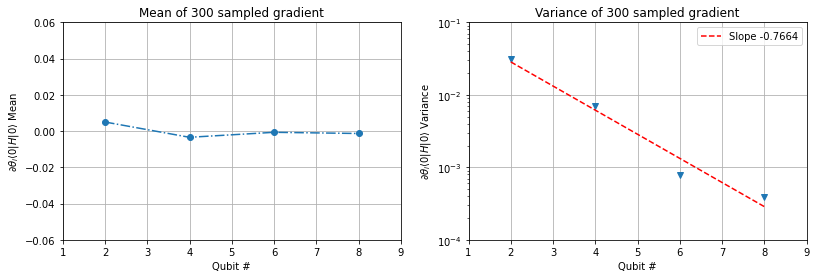

In [6]:
grad = np.array(grad_val)
means = np.array(means)
variances = np.array(variances)
n = np.array(selected_qubit)
print("We then draw the statistical results of this sampled gradient:")
fig = plt.figure(figsize=plt.figaspect(0.3))


# ============= The first figure =============
# Calculate the relationship between the average gradient of random sampling and the number of qubits
plt.subplot(1, 2, 1)
plt.plot(n, means, "o-.")
plt.xlabel(r"Qubit #")
plt.ylabel(r"$ \partial \theta_{i} \langle 0|H |0\rangle$ Mean")
plt.title("Mean of {} sampled gradient".format(samples))
plt.xlim([1,9])
plt.ylim([-0.06, 0.06])
plt.grid()

# ============= The second figure =============
# Calculate the relationship between the variance of the randomly sampled gradient and the number of qubits
plt.subplot(1, 2, 2)
plt.semilogy(n, variances, "v")

# Polynomial fitting
fit = np.polyfit(n, np.log(variances), 1)
slope = fit[0] 
intercept = fit[1] 
plt.semilogy(n, np.exp(n * slope + intercept), "r--", label="Slope {:03.4f}".format(slope))
plt.xlabel(r"Qubit #")
plt.ylabel(r"$ \partial \theta_{i} \langle 0|H |0\rangle$ Variance")
plt.title("Variance of {} sampled gradient".format(samples))
plt.legend()
plt.xlim([1,9])
plt.ylim([0.0001, 0.1])
plt.grid()

plt.show()

It should be noted that, in theory, only when the network structure and loss function we choose meet certain conditions (unitary 2-design), see paper [[1]](https://arxiv.org/abs/1803.11173), this effect will appear. Then we might as well visualize the influence of choosing different qubits on the optimization landscape:

![BP-fig-qubit_landscape_compare](./figures/BP-fig-qubit_landscape_compare.png "(a) Optimization landscape sampled for 2,4,and 6 qubits from left to right in different z-axis scale. (b) Same landscape in a fixed z-axis scale.")
<div style="text-align:center">(a) Optimization landscape sampled for 2,4,and 6 qubits from left to right in different z-axis scale. (b) Same landscape in a fixed z-axis scale. </div>


$\theta_1$ and $\theta_2$ are the first two circuit parameters, and the remaining parameters are all fixed to $\pi$. This way, it helps us visualize the shape of this high-dimensional manifold. Unsurprisingly, the landscape becomes more flat as $n$ increases. **Notice the rapidly decreasing scale in the $z$-axis**. Compared with the 2-qubit case, the optimized landscape of 6 qubits is very flat.

_______

## References

[1] McClean, J. R., Boixo, S., Smelyanskiy, V. N., Babbush, R. & Neven, H. Barren plateaus in quantum neural network training landscapes. [Nat. Commun. 9, 4812 (2018).](https://www.nature.com/articles/s41467-018-07090-4)

[2] Cerezo, M., Sone, A., Volkoff, T., Cincio, L. & Coles, P. J. Cost-Function-Dependent Barren Plateaus in Shallow Quantum Neural Networks. [arXiv:2001.00550 (2020).](https://arxiv.org/abs/2001.00550)